In [319]:
import Insole_Processing_Steps as proc
import DatabaseManage
import MLClassification as ml
import MergeSteps as ms
import os

if the database already exists: 

Use already existing Database, get Data from the Database

In [320]:

######### TODO Change Database File AND smooth and numFeatures variables
numFeatures=9 # if number is 9 : 9 features extracted from the matrix , there are 10 features in total, the last one is the time
smooth=0.5
numberMergeSteps= 2 # adjust number of steps which should be merged to one step (for numStep=1 every step is considered individually) (takes the medium value of all features)
numberAddSteps= 9 #9 # adjust number of steps which should be concatenated to be the features of one step (for numStep=1 every step is considered individually) (concatenates the features of the list to a larger list)
takeTimeAsFeature= False#True # change to false, if you don't want the time as an additional feature

# list with all persons that are extracted from the database (all existing persons: [3,4,5,6,7,9,10,11,12,23,26,27,28])
persons= [4,6,7,9,10,11,12,23,26,27,28]#[4,6,7,10,11,12,23,26,27,28]
totalSteps= 500 # number of total steps that are extracted from the database for each person (max. 500)

#db_file ='.//Database//insole5min_Smooth0.5Features4.db'
#db_file ='.//Database//Paper_insole_Smooth0Features9.db'
db_file= f'.//Database//new//insole_Smooth{smooth}Features{numFeatures+1}_total500steps.db'
#db_file= './/Database//new//insole_Smooth0Features10_total500steps.db'
########################################

allStepFeatureLists=[]

if takeTimeAsFeature:
    numFeatures+=1
    
    
for person in persons:
    
    stepFeaturesPers= DatabaseManage.getStepList(db_file, person, numFeatures)
    print(stepFeaturesPers)
     # function to merge steps to one step
    stepFeaturesPers= ms.mergeSteps(stepFeaturesPers, numFeatures, numberMergeSteps)
    # function to add the features of several steps to one step
    stepFeaturesPers= ms.appendSteps(stepFeaturesPers, numFeatures, numberAddSteps)
    allStepFeatureLists.append(stepFeaturesPers)

[[[0.0, 0.0, 0.0, 0.0, 0.0, 64.94444444444444, 49.666666666666664, 11.944444444444445, 656.4444444444443], [0.0, 0.0, 0.0, 0.0, 0.0, 64.94444444444444, 49.666666666666664, 11.944444444444445, 656.4444444444443], [0.0, 0.0, 0.0, 0.0, 0.0, 64.94444444444444, 49.666666666666664, 11.944444444444445, 656.4444444444443], [0.0, 0.0, 0.0, 0.0, 0.0, 64.94444444444444, 49.666666666666664, 11.944444444444445, 656.4444444444443], [0.0, 0.0, 0.0, 0.0, 0.0, 64.94444444444444, 49.666666666666664, 11.944444444444445, 656.4444444444443], [0.0, 0.0, 0.0, 0.0, 0.0, 64.94444444444444, 49.666666666666664, 11.944444444444445, 656.4444444444443], [0.0, 0.0, 0.0, 0.0, 0.0, 64.94444444444444, 49.666666666666664, 11.944444444444445, 656.4444444444443], [0.0, 0.0, 0.0, 0.0, 0.0, 64.94444444444444, 49.666666666666664, 11.944444444444445, 656.4444444444443]], [[3.875, 2.4166666666666665, 1.3611111111111112, 0.0, 0.0, 91.94444444444443, 156.5, 27.333333333333336, 565.3888888888889], [1.9375, 1.2083333333333333, 0.6

create a train and a test set for the data

In [321]:
import random
## TODO adjust the total number for 70% and 100%
#totalSteps= 500
#trainEnd= 511#80 #98# 77 
#testEnd= 730#110#140# 110 
#################################################
# 70% von der Zahl berechnen
trainEnd = int(totalSteps/(numberMergeSteps*numberAddSteps) * 0.7)
# 30% von der Zahl berechnen
testEnd = totalSteps

# create test and train set
trainFeatures=[]
trainLabels=[]

testFeatures=[]
testLabels=[]

personIndex=0
personList=[]#[0,1,2,3,4,5,6,7,8,9,10,11,12,13]#[0,1,2,3,4,5,6,7,8] # list for labels
#i=0

for stepFeatureList in allStepFeatureLists:
    # Eine Kopie der Liste erstellen
    stepFeatureListRand = stepFeatureList.copy()
    # Die Elemente in der Kopie zufällig mischen
    random.shuffle(stepFeatureListRand, random=0)
    personList.append(personIndex)
    label= personList[personIndex]
    trainFeatures, trainLabels, testFeatures, testLabels= ml.extendTrainAndTestSet(stepFeatureListRand,label, trainEnd, testEnd, trainFeatures, trainLabels, testFeatures, testLabels)
    personIndex+=1
    

run ML Classifiers

In [322]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib
import HelpFunctions
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']= 24

def runClassifiers(trainFeatures, testFeatures, trainLabels, testLabels, numOfFeatures,smoothFactor,steps, save_results_to, xlabels,ylabels,  numberSteps, numberAddSteps):
    # first, initialize the classificators
    tree= DecisionTreeClassifier(random_state=42) # using the random state for reproducibility
    forest= RandomForestClassifier(random_state=42)
    knn= KNeighborsClassifier()
    svm= SVC(random_state=42)
    #svm2= SVC(kernel="linear", C=0.025, random_state=42)
    xboost= XGBClassifier(random_state=42)
    #clf = GaussianNB()

    # X = df_train.drop(['y'] , axis=1)
    # y = df_train['y']

    # X_test = df_test.drop(['y'] , axis = 1)
    # y_test = df_test['y']
    acc = []
    other_accuracy=[]
    mo = []
    #models= [tree, forest, knn, svm, xboost]
    models= [tree,forest,knn, svm, xboost]

    #X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2 , random_state=42)
    X_train= trainFeatures
    X_test= testFeatures
    y_train= trainLabels
    y_test= testLabels
    HelpFunctions.replace_none_with_zero(X_train)
    HelpFunctions.replace_inf_with_zero(X_train)
    #round_float_to_int(X_train)
    #print(X_train)
    HelpFunctions.replace_none_with_zero(X_test)
    HelpFunctions.replace_inf_with_zero(X_test)
    #round_float_to_int(X_test)
    #print(X_test)

    #print(X_train)
    #print(y_train)

    #print(len(X_train))
    #print(len(y_train))

    for model in models:
        model.fit(X_train,y_train) # fit the model
        y_pred= model.predict(X_test) # then predict on the test set
        accuracy= accuracy_score(y_test, y_pred) # this gives us how often the algorithm predicted correctly
        other_acc= balanced_accuracy_score(y_test,y_pred)
        other_accuracy.append(other_accuracy)
        acc.append(accuracy)
        clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
        print(f"The accuracy of model {type(model).__name__} is {accuracy:.3f}")
        print(f"The \"other accuracy\" of model {type(model).__name__} is {other_acc:.3f}")
        mo.append(type(model).__name__)
        print(clf_report)
        # plot confusion Matrix
        
        cm = confusion_matrix(y_test, y_pred)
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Create a custom color palette for the heatmap with a single color
        cmap = sns.color_palette("Blues", as_cmap=True)

        fig, ax = plt.subplots(figsize=(14, 14))

        # Anpassungen für bessere Lesbarkeit und einheitliche Intensität
        sns.heatmap(cmn, annot=True, fmt='.2f', cmap=cmap, linewidths=0.5, square=True, xticklabels=xlabels,yticklabels=ylabels,annot_kws={"fontsize": 16, "color": 'black'})  # Verwendung der Schriftfarbe 'black'

        # Customize labels und Farben
        ax.set_xlabel('Predicted', fontsize=18)
        ax.set_ylabel('Actual', fontsize=18)
        ax.set_title(f'{type(model).__name__} Confusion Matrix {numOfFeatures} Features {numberSteps} merged Steps', fontsize=24, pad=20)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        # Add colorbar
        cbar = ax.collections[0].colorbar
        cbar.set_label('Normalized Values', fontsize=16)

        # Save the figure and display it
        #plt.savefig(save_results_to + f'{type(model).__name__}_Confusion Matrix_{numOfFeatures}Features_SmoothFactor{smoothFactor}_TotalSteps{steps}_MergedSteps{numberSteps}.pdf', dpi=300, bbox_inches='tight')
        plt.savefig(save_results_to + f'{type(model).__name__}_Confusion Matrix_{numOfFeatures}Features_SmoothFactor{smoothFactor}_TotalSteps{steps}_MergedSteps{numberSteps}_ConcatenatedSteps{numberAddSteps}.pdf', dpi=300, bbox_inches='tight')
        plt.show()

        print("\n")

    print('------------------------------------------------------------------------------------')
   # clf = AdaBoostClassifier(n_estimators=100)
   # scores = cross_val_score(clf, X, y, cv=5)
   # print(scores.mean())

The accuracy of model DecisionTreeClassifier is 0.875
The "other accuracy" of model DecisionTreeClassifier is 0.875
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       0.86      0.75      0.80         8
           3       0.75      0.75      0.75         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       0.67      0.75      0.71         8
           7       0.83      0.62      0.71         8
           8       0.78      0.88      0.82         8
           9       1.00      0.88      0.93         8
          10       0.80      1.00      0.89         8

    accuracy                           0.88        88
   macro avg       0.88      0.88      0.87        88
weighted avg       0.88      0.88      0.87        88



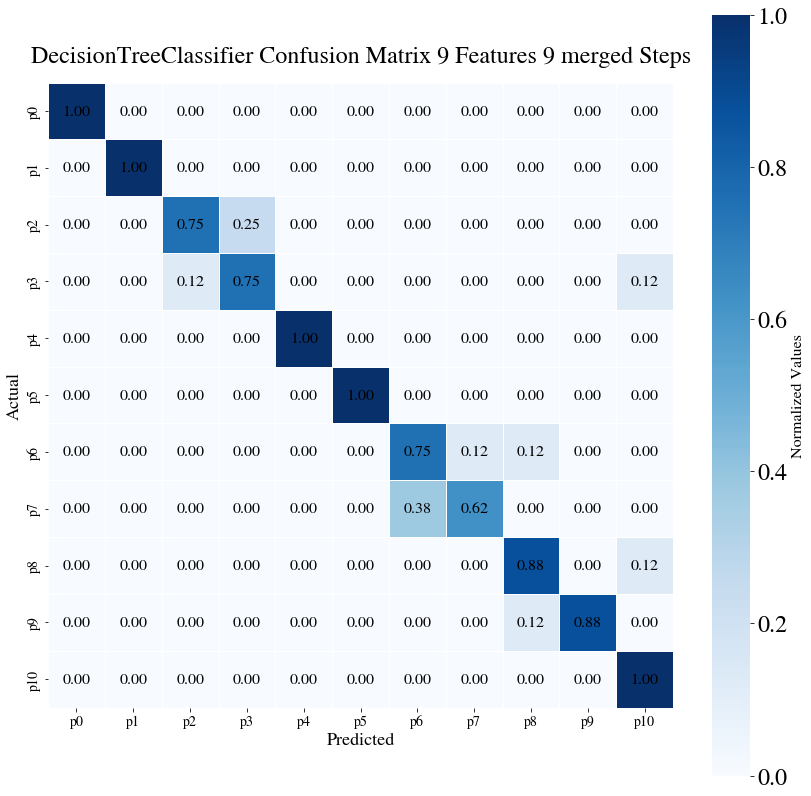



The accuracy of model RandomForestClassifier is 0.898
The "other accuracy" of model RandomForestClassifier is 0.898
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       0.86      0.75      0.80         8
           3       0.78      0.88      0.82         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       0.62      0.62      0.62         8
           7       0.62      0.62      0.62         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8

    accuracy                           0.90        88
   macro avg       0.90      0.90      0.90        88
weighted avg       0.90      0.90      0.90        88



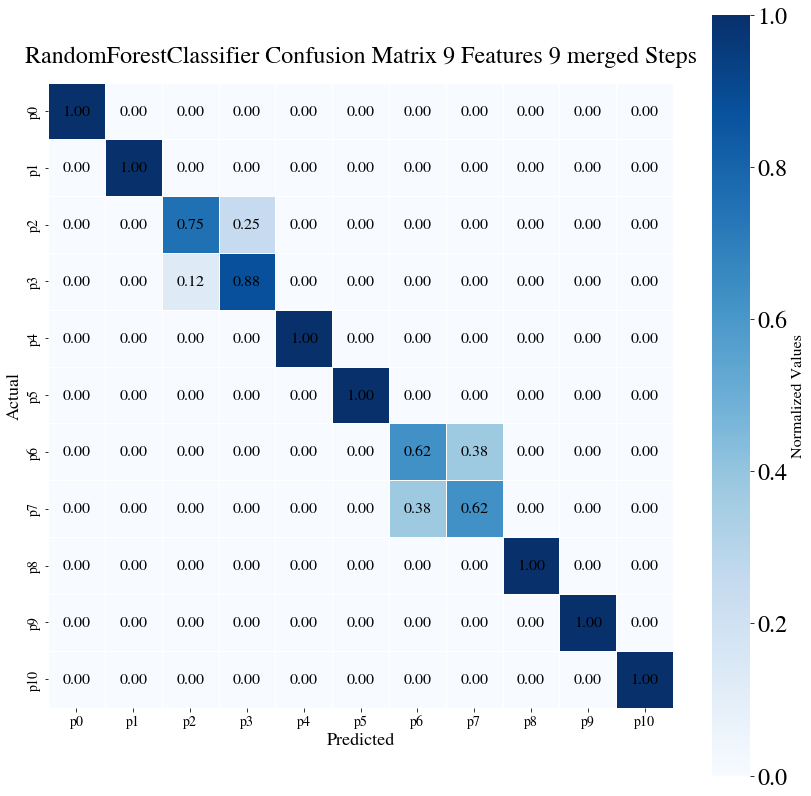



The accuracy of model KNeighborsClassifier is 0.886
The "other accuracy" of model KNeighborsClassifier is 0.886
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       0.88      0.88      0.88         8
           3       0.83      0.62      0.71         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      0.25      0.40         8
           7       0.57      1.00      0.73         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       0.80      1.00      0.89         8

    accuracy                           0.89        88
   macro avg       0.92      0.89      0.87        88
weighted avg       0.92      0.89      0.87        88



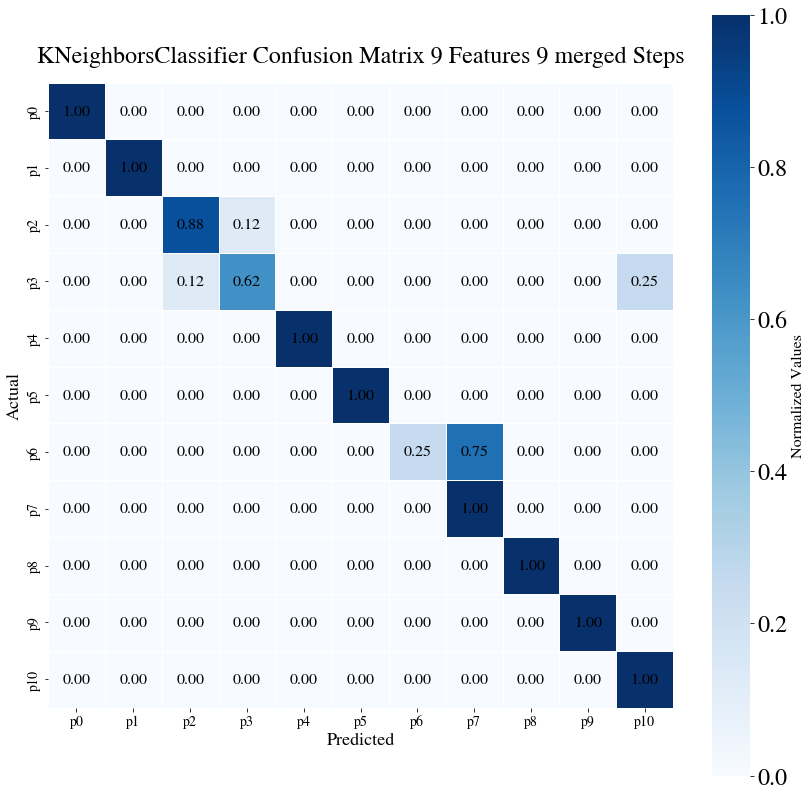



The accuracy of model SVC is 0.909
The "other accuracy" of model SVC is 0.909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       0.83      0.62      0.71         8
           3       0.70      0.88      0.78         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      0.50      0.67         8
           7       0.67      1.00      0.80         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8

    accuracy                           0.91        88
   macro avg       0.93      0.91      0.91        88
weighted avg       0.93      0.91      0.91        88



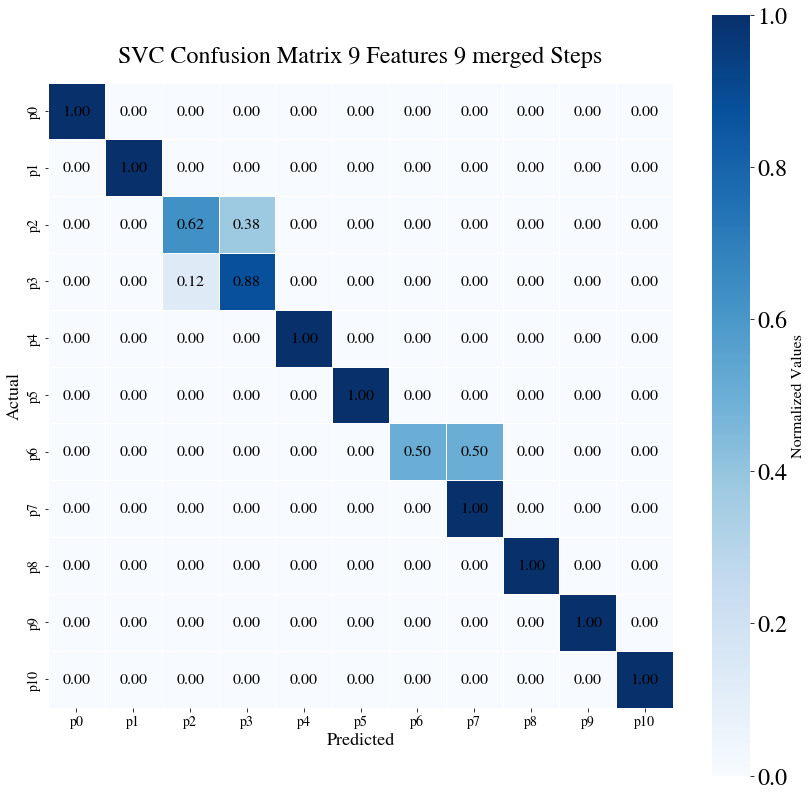



The accuracy of model XGBClassifier is 0.864
The "other accuracy" of model XGBClassifier is 0.864
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       0.62      0.62      0.62         8
           3       0.71      0.62      0.67         8
           4       0.89      1.00      0.94         8
           5       1.00      1.00      1.00         8
           6       0.62      0.62      0.62         8
           7       0.62      0.62      0.62         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8

    accuracy                           0.86        88
   macro avg       0.86      0.86      0.86        88
weighted avg       0.86      0.86      0.86        88



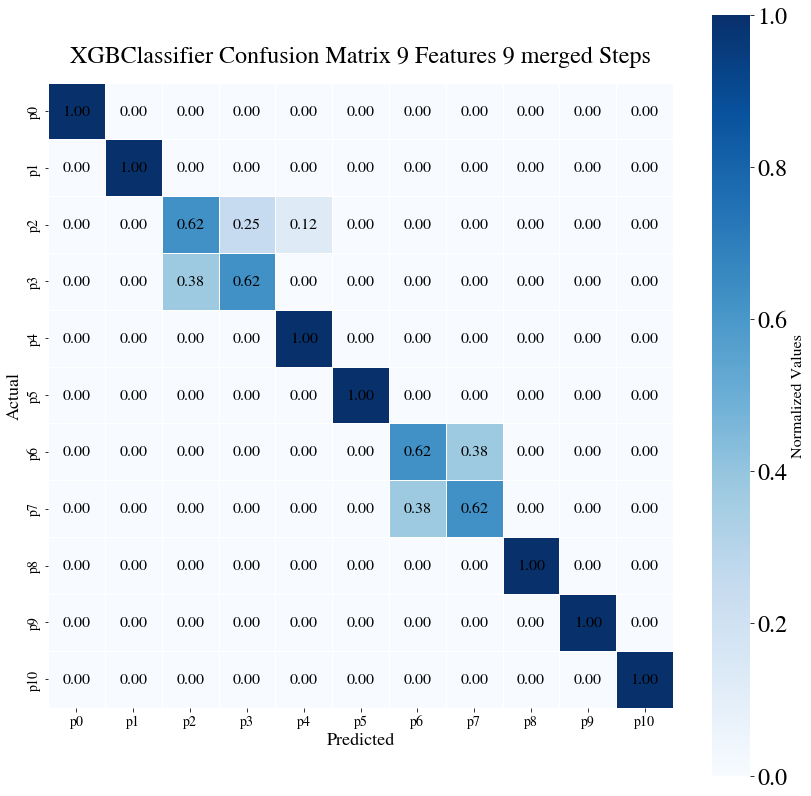



------------------------------------------------------------------------------------


In [323]:
##############  TODO adjust x and y labels if the number of persons changes
#numOfFeatures=9
#smoothFactor=0
#steps= 500# 110
#save_results_to = './ConfMatrices/5min/' # for the "old" data
save_results_to = './ConfMatrices/new/3D/mergedSteps/' #modified/' # for the "new" data
####################################

# labels für personen
xlabels=[]#['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13']
ylabels=[]#['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13']
for i in personList:
    xlabels.append(f"p{i}")
    ylabels.append(f"p{i}")

#ml.runClassifiers(trainFeatures, testFeatures, trainLabels, testLabels, numFeatures,smooth,totalSteps, save_results_to, xlabels, ylabels)
runClassifiers(trainFeatures, testFeatures, trainLabels, testLabels, numFeatures,smooth,totalSteps, save_results_to, xlabels, ylabels, numberAddSteps, numberAddSteps)

In [324]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import HelpFunctions

x_train= trainFeatures
x_test= testFeatures
y_train= trainLabels
y_test= testLabels
HelpFunctions.replace_none_with_zero(x_train)
HelpFunctions.replace_inf_with_zero(x_train)   
HelpFunctions.replace_none_with_zero(x_test)
HelpFunctions.replace_inf_with_zero(x_test)
# Modell erstellen
model = keras.Sequential([
    #layers.Flatten(input_shape=(72)),
    #completely connected layer with number of neurons and activation function
    layers.Dense(256, activation='relu'),# 128
    # deactivate random part of the neurons to avoid overfitting (0.2 is the probability that a neuron is deactivated)
    layers.Dropout(0.2),
    #layers.Dense(32, activation='relu'),
    # number indicates the number of classes, softmax to convert to probabilities (Ausgabeschicht)
    layers.Dense(13, activation='softmax')
    
])

# Modell kompilieren
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



# Modell trainieren
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Modell bewerten
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test Genauigkeit: {test_acc}')

Epoch 1/10
7/7 [==============================] - 1s 72ms/step - loss: 209.8441 - accuracy: 0.3493 - val_loss: 64.3929 - val_accuracy: 0.5909
Epoch 2/10
7/7 [==============================] - 0s 11ms/step - loss: 50.4125 - accuracy: 0.6507 - val_loss: 16.4829 - val_accuracy: 0.8409
Epoch 3/10
7/7 [==============================] - 0s 15ms/step - loss: 20.5910 - accuracy: 0.8612 - val_loss: 13.3098 - val_accuracy: 0.8750
Epoch 4/10
7/7 [==============================] - 0s 10ms/step - loss: 11.4441 - accuracy: 0.8947 - val_loss: 13.5141 - val_accuracy: 0.8750
Epoch 5/10
7/7 [==============================] - 0s 11ms/step - loss: 9.6613 - accuracy: 0.8995 - val_loss: 18.8302 - val_accuracy: 0.8636
Epoch 6/10
7/7 [==============================] - 0s 12ms/step - loss: 8.2776 - accuracy: 0.9234 - val_loss: 11.6316 - val_accuracy: 0.8977
Epoch 7/10
7/7 [==============================] - 0s 10ms/step - loss: 7.4965 - accuracy: 0.9330 - val_loss: 16.3829 - val_accuracy: 0.8750
Epoch 8/10
7/7 